In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
def to_float(cell_content) -> float:
    try:
        return float(cell_content)
    except:
        return np.nan


shanghai = pd.read_excel(
    "shanghai.xlsx",
    sheet_name="Sheet4",
    header=0,
    names=[
        "name",  # 小区名称
        "price",  # 均价
        "region",  # 区域
        "block",  # 板块
        "subway",  # 地铁
        "address",  # 地址
        "built_year",  # 建筑年代
        "building_type",  # 建筑类型
        "property_costs",  # 物业费用
        "property_management_company",  # 物业公司
        "developer",  # 开发商
        "total_number_of_buildings",  # 楼栋总数
        "total_number_of_houses",  # 房屋总数
        "longitude_baidu_coordinates",  # 经度_百度坐标
        "latitude_baidu_coordinates",  # 纬度_百度坐标
        "longitude_wgs1984_coordinates",  # 经度_WGS1984坐标
        "latitude_wgs1984_coordinates",  # 纬度_WGS1984坐标
    ],
    converters={
        "price": to_float,
        "longitude_wgs1984_coordinates": to_float,
        "latitude_wgs1984_coordinates": to_float,
    },
)
shanghai.dropna(
    subset=["price", "longitude_wgs1984_coordinates", "latitude_wgs1984_coordinates"],
    inplace=True,
)
print(f"number of samples = {len(shanghai)}")


number of samples = 11681


In [3]:
shanghai_center = pd.read_csv("shanghai_center.csv")
print(f"number of centers = {len(shanghai_center)}")


number of centers = 35


In [4]:
price = shanghai["price"]
longitude = shanghai["longitude_wgs1984_coordinates"]
latitude = shanghai["latitude_wgs1984_coordinates"]
degree_to_kilometer = (np.pi / 180.0) * 6371
x = longitude * degree_to_kilometer
y = latitude * degree_to_kilometer


In [5]:
name = shanghai_center["name"]
x_center = shanghai_center["longitude"] * degree_to_kilometer
y_center = shanghai_center["latitude"] * degree_to_kilometer


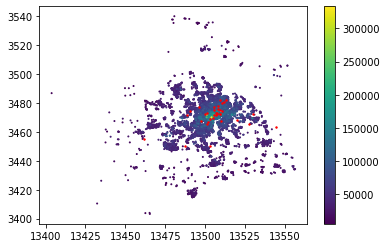

In [6]:
plt.figure()
plt.scatter(x, y, 1, price)
plt.colorbar()
plt.scatter(x_center, y_center, 2, c="red")
plt.savefig("shanghai.png")


In [7]:
def calculate_x(x, y, x_center, y_center, name):
    data = np.ones((len(x), len(x_center))) * np.nan
    data = pd.DataFrame(data, columns=name)
    for i in range(len(x_center)):
        data[name[i]] = np.sqrt((x - x_center[i]) ** 2 + (y - y_center[i]) ** 2)
        pass
    return data


data = calculate_x(x, y, x_center, y_center, name)
data["price"] = price


In [8]:
import statsmodels.formula.api as smf

model = smf.ols(f"np.log(price) ~ {'+'.join(name)}", data=data)
results = model.fit()
print(results.summary(), file=open("shanghai_result.txt", mode="w"))
params = results.params
params.drop(["Intercept"], inplace=True)
shanghai_center["coef"] = params.to_numpy()


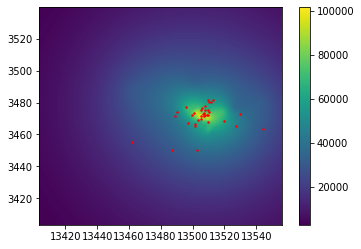

In [9]:
n_x = 100
n_y = 100
x_fit = np.linspace(x.min(), x.max(), n_x)
y_fit = np.linspace(y.min(), y.max(), n_y)
x_fit, y_fit = np.meshgrid(x_fit, y_fit)
x_fit = np.reshape(x_fit, (-1,))
y_fit = np.reshape(y_fit, (-1,))
data_fit = calculate_x(x_fit, y_fit, x_center, y_center, shanghai_center["name"])
price_fit = results.predict(data_fit)
price_fit = np.exp(np.reshape(price_fit.to_numpy(), (n_x, n_y)))

plt.figure()
plt.imshow(price_fit, extent=(x_fit.min(), x_fit.max(), y_fit.min(), y_fit.max()))
plt.colorbar()
plt.scatter(x_center, y_center, 2, c="red")
plt.savefig("shanghai_predict.png")


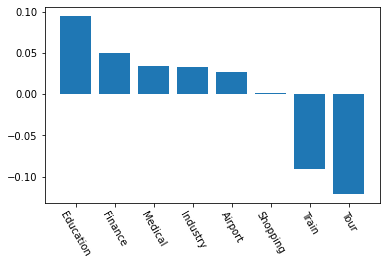

In [10]:
score = dict.fromkeys(shanghai_center["category"].unique(), 0)
for i in range(len(shanghai_center)):
    score[shanghai_center["category"][i]] -= shanghai_center["coef"][i]
    pass

categories = sorted(score.keys(), key=score.__getitem__, reverse=True)
plt.figure()
plt.bar(range(len(score)), sorted(score.values(), reverse=True))
plt.xticks(range(len(score)), categories, rotation=300)
plt.subplots_adjust(bottom=0.2)
plt.savefig("shanghai_impact.png")
